In [1]:
import timm
import minloraplus
from minloraplus.model import add_lora_by_name
import pytorch_lightning as pl
import torchvision
import torch
import torchmetrics
from functools import partial
import os

In [2]:
from torchvision import datasets

In [3]:
train_trans = torchvision.transforms.Compose([      torchvision.transforms.Resize((224, 224)),
                                                    torchvision.transforms.RandAugment(3, 7),
                                                    torchvision.transforms.ToTensor()]
    )

test_transforms = torchvision.transforms.Compose(
        [torchvision.transforms.Resize((224, 224)), torchvision.transforms.ToTensor()]
    )

In [9]:
flowers_train = datasets.Flowers102("./", split="train", download=True, transform=train_trans)
flowers_test = datasets.Flowers102("./", split="test", download=True, transform=test_transforms)

In [10]:
train_dl = torch.utils.data.DataLoader(flowers_train,
                                       batch_size=64,
                                       shuffle=True, num_workers=os.cpu_count())

test_dl = torch.utils.data.DataLoader(flowers_test,
                                      batch_size=64, num_workers = os.cpu_count())

(6149, 1020, 1020)

In [11]:
for b in train_dl:
    print(b[0].shape, b[1].shape)

In [12]:
for b in test_dl:
    print(b[0].shape, b[1].shape)

torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([6

KeyboardInterrupt: 

In [13]:
b[0].shape, b[1].shape

torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([60, 3, 224, 224]) torch.Size([60])


KeyboardInterrupt: 

In [14]:
import matplotlib.pyplot as plt

(torch.Size([60, 3, 224, 224]), torch.Size([60]))

In [15]:
plt.figure()
plt.imshow(torch.moveaxis(b[0][0],0, -1))
plt.show()

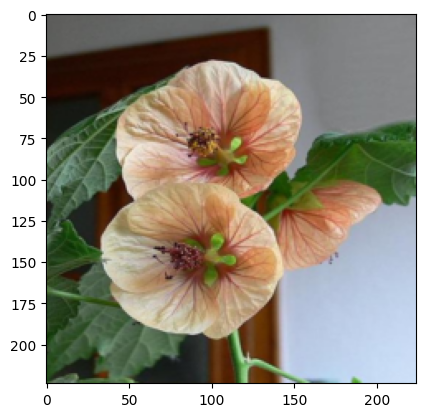

In [16]:
class Classifier(pl.LightningModule):

    def __init__(self, num_classes, model_name='vit_tiny_r_s16_p8_224', img_size=224):
        super().__init__()
        self.model  = timm.create_model(
                                model_name,
                                img_size=img_size,
                                pretrained=True,
                                num_classes=num_classes,  # remove classifier nn.Linear
                            )
        for n, p in self.model.named_parameters():
            if "head" not in n:
                p.requires_grad = False
        config = {
            torch.nn.Linear: {
                "weight": partial(minloraplus.LoRAParametrization.from_linear, rank=8),
            },
        }
        add_lora_by_name(self.model, ["qkv"], lora_config=config)
        self.criterion = torch.nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes).to(self.device)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch: tuple, batch_idx: int) -> torch.TensorType:
        x, y = batch
        y_hat = self.forward(x)
        loss = self.criterion(y_hat, y)
        acc = self.accuracy(torch.argmax(y_hat, dim=1), y)
        self.log(f'train_loss', loss, prog_bar=True, on_step=True)
        self.log(f'train_acc', acc, prog_bar=True, on_step=True)
        return loss

    def validation_step(self, batch: tuple, batch_idx: int) -> torch.TensorType:
        x, y = batch
        y_hat = self.forward(x)
        loss = self.criterion(y_hat, y)
        acc = self.accuracy(torch.argmax(y_hat, dim=1), y)
        self.log(f'val_loss', loss, prog_bar=True, on_step=True)
        self.log(f'val_acc', acc, prog_bar=True, on_step=True)
        return loss

    def configure_optimizers(self) -> torch.optim.Optimizer:
        """
        Configures the optimizer for training.

        Returns:
        - optimizer (torch.optim.Optimizer): The optimizer object.
        """
        optimizer = torch.optim.AdamW(self.parameters(), lr=0.0001)
        return optimizer

In [17]:
classifier = Classifier(102)

In [18]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [19]:
print_trainable_parameters(classifier.model)

In [20]:
trainer = pl.Trainer(
        precision=16,
        accelerator="mps" if torch.has_mps else "cpu",
        devices=1,
        max_epochs=30
    )

trainable params: 93414 || all params: 6238118 || trainable%: 1.4974708718238416


In [21]:
trainer.fit(classifier, train_dataloaders=train_dl, val_dataloaders=test_dl)

/Users/jameskelly/miniconda3/envs/pytorch/lib/python3.10/site-packages/lightning_fabric/connector.py:562: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
Using 16bit Automatic Mixed Precision (AMP)
/Users/jameskelly/miniconda3/envs/pytorch/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



  | Name      | Type              | Params
------------------------------------------------
0 | model     | VisionTransformer | 6.2 M 
1 | criterion | CrossEntropyLoss  | 0     
2 | accuracy  | Accuracy          | 0     
------------------------------------------------
93.4 K    Trainable params
6.1 M     Non-trainable params
6.2 M     Total params
24.952    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/jameskelly/miniconda3/envs/pytorch/lib/python3.10/site-packages/torch/amp/autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/Users/jameskelly/miniconda3/envs/pytorch/lib/python3.10/site-packages/torchmetrics/utilities/checks.py:46: UserWarning: MPS: no support for int64 min/max ops, casting it to int32 (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/ReduceOps.mm:1271.)
  if ignore_index is None and target.min() < 0:


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

ERROR: Unexpected segmentation fault encountered in worker.
 Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x138f52b90>
Traceback (most recent call last):
  File "/Users/jameskelly/miniconda3/envs/pytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/Users/jameskelly/miniconda3/envs/pytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1442, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/jameskelly/miniconda3/envs/pytorch/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/Users/jameskelly/miniconda3/envs/pytorch/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/Users/jameskelly/miniconda3/envs/pytorch/lib/python3.10/multiprocessing/connection.py", line 936, in wait
    ready = selector.select(timeout)
 

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
